# SafeSwipe:Credit card fraud detection using feature engineering

### Author: Sinegugu Mthembu

In [1]:
#import libraries some of these I might not use but just to have them.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import pickle

import itertools
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from collections import Counter

import xgboost as xgb
from xgboost import XGBClassifier  
from xgboost import XGBRegressor  
from sklearn.metrics import mean_squared_error

import warnings

# The data was sourced from JP Morgan: Synthetic data
#### The data was generated by running an AI planning-execution simulator and translating the output planning traces into tabular format. Parameters of the data generation model include the number of clients, time duration and probabilities of fraud.

In [20]:
#Importing and reading the data
data2 = pd.read_csv('fraud_payment_data.csv')

#Had to to fix some of the country names as they were written in different formats
countries = pd.read_csv('Countries.csv') 
updated_countries= pd.read_csv('updated_countries.csv')
#updated_countries.shape


In [21]:
# Set column names for the 'countries' DataFrame
countries.columns = ['Countries']

# Set column names for the 'updated_countries' DataFrame
updated_countries.columns = ['unrec_Country', 'rec_Country']

# Display the first few rows of both DataFrames to verify the changes

print("\nUpdated 'updated_countries' DataFrame:")
print(updated_countries.head())



Updated 'updated_countries' DataFrame:
           unrec_Country          rec_Country
0      SAO TOME PRINCIPE    SAO TOME PRINCIPE
1          FAROE ISLANDS              DENMARK
2    ANTIGUA AND BARBUDA  ANTIGUA AND BARBUDA
3          ALAND ISLANDS              FINLAND
4  VIRGIN ISLANDS (U.S.)        UNITED STATES


In [22]:
#How many rows and colums of the credit card data?
data2.shape

(1498177, 13)

In [23]:
#First 5 rows from the data
data2.head()


,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2022-03-15 10:24:00,EXCHANGE-10115,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,CCB,NaN,NaN,NaN,558.43,0,WITHDRAWAL
1,2022-03-15 10:24:00,QUICK-PAYMENT-10116,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,2022-03-15 10:24:00,DEPOSIT-CASH-9833,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,2022-03-15 10:24:00,PAY-CHECK-9832,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,CCB,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,2022-03-15 10:24:00,DEPOSIT-CHECK-9806,NaN,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK


In [24]:
#Checking the details of the three float columns
data2.describe()

,Sender_Sector,USD_amount,Label
count,1.279291e+06,1.498177e+06,1.498177e+06
mean,2.502133e+04,5.134698e+02,2.057100e-02
std,1.443171e+04,5.398089e+02,1.419431e-01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.253400e+04,1.386900e+02,0.000000e+00
50%,2.502300e+04,4.041600e+02,0.000000e+00
75%,3.753050e+04,7.340700e+02,0.000000e+00
max,4.999900e+04,1.999894e+04,1.000000e+00


In [25]:
#Checking the details of non numeric columns
data2.describe(include=object)

,Time_step,Transaction_Id,Sender_Id,Sender_Account,Sender_Country,Sender_lob,Bene_Id,Bene_Account,Bene_Country,Transaction_Type
count,1498177,1498177,1279291,1279291,1279291,1279291,1282284,1282284,1282284,1498177
unique,639300,1498177,59071,75161,252,1,279357,295031,252,8
top,2051-01-26 03:27:02,EXCHANGE-10115,JPMC-CLIENT-1730807,ACCOUNT-1591424,USA,CCB,JPMC-CLIENT-1119942,ACCOUNT-1029621,USA,MAKE-PAYMENT
freq,100,1,157,99,997236,1279291,80,61,757908,557735


In [26]:
#checking for duplicates
data2.duplicated().sum()

0

In [27]:
#Checking the different columns and the number of values in each
data2.count()

Time_step           1498177
Transaction_Id      1498177
Sender_Id           1279291
Sender_Account      1279291
Sender_Country      1279291
Sender_Sector       1279291
Sender_lob          1279291
Bene_Id             1282284
Bene_Account        1282284
Bene_Country        1282284
USD_amount          1498177
Label               1498177
Transaction_Type    1498177
dtype: int64

##### The deposit type transactions do not have all the information that is why there is consistency in the null valeu distribution

In [28]:
#Checking for null values
#data2.isnull().sum()
null_perc = (data2.isnull().sum() / len(data2)) * 100
null_per_column = pd.DataFrame({"Column name": data2.columns, "Null percentage": null_perc.round(2)})
print(null_per_column)


                       Column name  Null percentage
Time_step                Time_step             0.00
Transaction_Id      Transaction_Id             0.00
Sender_Id                Sender_Id            14.61
Sender_Account      Sender_Account            14.61
Sender_Country      Sender_Country            14.61
Sender_Sector        Sender_Sector            14.61
Sender_lob              Sender_lob            14.61
Bene_Id                    Bene_Id            14.41
Bene_Account          Bene_Account            14.41
Bene_Country          Bene_Country            14.41
USD_amount              USD_amount             0.00
Label                        Label             0.00
Transaction_Type  Transaction_Type             0.00


In [29]:
#Calculating the null valeus for each of the transaction types
transaction_types =  ['EXCHANGE', 'DEPOSIT-CHECK', 'WITHDRAWAL', 'MAKE-PAYMENT','QUICK-PAYMENT','MOVE-FUNDS','PAY-CHECK','DEPOSIT-CASH']  

# Create an empty dictionary to store results
null_counts = {}

# Loop through each transaction type
for transaction_type in transaction_types:
    # Filter the DataFrame for the current transaction type
    filtered_data = data2[data2['Transaction_Type'] == transaction_type]
    
    # Count the number of null values for each column in the filtered data
    null_counts[transaction_type] = filtered_data.isnull().sum()

# Print the null value counts for each transaction type
for transaction_type, counts in null_counts.items():
    print(f"Null value counts for {transaction_type}:")
    print(counts)
    print()


Null value counts for EXCHANGE:
Time_step                0
Transaction_Id           0
Sender_Id                0
Sender_Account           0
Sender_Country           0
Sender_Sector            0
Sender_lob               0
Bene_Id             108167
Bene_Account        108167
Bene_Country        108167
USD_amount               0
Label                    0
Transaction_Type         0
dtype: int64

Null value counts for DEPOSIT-CHECK:
Time_step                0
Transaction_Id           0
Sender_Id           109477
Sender_Account      109477
Sender_Country      109477
Sender_Sector       109477
Sender_lob          109477
Bene_Id                  0
Bene_Account             0
Bene_Country             0
USD_amount               0
Label                    0
Transaction_Type         0
dtype: int64

Null value counts for WITHDRAWAL:
Time_step                0
Transaction_Id           0
Sender_Id                0
Sender_Account           0
Sender_Country           0
Sender_Sector            0
Sende

In [30]:
#This column can be dropped because the sender lob is the same for all transactions except for cash deposit where there is no Sender lob
#data2['Sender_lob'].value_counts()

data2.drop('Sender_lob',axis=1,inplace=True)
data2.drop('Transaction_Id',axis=1,inplace=True)

data2.head()
#data2.shape

,Time_step,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2022-03-15 10:24:00,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,NaN,NaN,NaN,558.43,0,WITHDRAWAL
1,2022-03-15 10:24:00,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,2022-03-15 10:24:00,NaN,NaN,NaN,NaN,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,2022-03-15 10:24:00,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,2022-03-15 10:24:00,NaN,NaN,NaN,NaN,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK


In [31]:
data2.columns

Index(['Time_step', 'Sender_Id', 'Sender_Account', 'Sender_Country',
       'Sender_Sector', 'Bene_Id', 'Bene_Account', 'Bene_Country',
       'USD_amount', 'Label', 'Transaction_Type'],
      dtype='object')

In [32]:
# List of columns to check and replace 'Not Provided'
columns_to_check = ['Sender_Id','Sender_Account', 'Sender_Country','Sender_Sector','Bene_Account', 'Bene_Country','Bene_Id']

# Replace 'Not Provided' for each column in the list
for column in columns_to_check:
    data2[column] = data2.apply(lambda row: 'Not Provided' if pd.isna(row[column]) else row[column], axis=1)
    

In [33]:
data2.head()
#data2.isnull().sum()

,Time_step,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type
0,2022-03-15 10:24:00,JPMC-CLIENT-10098,ACCOUNT-10108,USA,35537.0,Not Provided,Not Provided,Not Provided,558.43,0,WITHDRAWAL
1,2022-03-15 10:24:00,JPMC-CLIENT-10098,ACCOUNT-10109,USA,15287.0,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT
2,2022-03-15 10:24:00,Not Provided,Not Provided,Not Provided,Not Provided,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH
3,2022-03-15 10:24:00,JPMC-CLIENT-9812,ACCOUNT-9825,USA,38145.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK
4,2022-03-15 10:24:00,Not Provided,Not Provided,Not Provided,Not Provided,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK


In [34]:
# Replace hyphens with spaces in countries with more than one word in their name
condition = data2["Sender_Country"].str.count('-') > 0
data2.loc[condition, "Sender_Country"] = data2.loc[condition, "Sender_Country"].apply(lambda x: x.replace('-', ' '))

# Display unique values in the "Sender_Country" column
unique_sender_countries = data2["Sender_Country"].unique()
#print(unique_sender_countries)

In [35]:
data2["Sender_Country"] = data2["Sender_Country"].replace(['USA'], 'UNITED STATES')
data2["Sender_Country"] = data2["Sender_Country"].replace(['CONGO DEM REP'], 'CONGO (DEMOCRATIC REPUBLIC)')
data2["Sender_Country"] = data2["Sender_Country"].replace(['CONGO REP'], 'CONGO (CONGO REP)')              
data2["Sender_Country"] = data2["Sender_Country"].replace(['COCOS KEELING IS'], 'AUSTRALIA') 
data2["Sender_Country"] = data2["Sender_Country"].replace(['RUSSIAN'], 'RUSSIA')

# Create a mapping dictionary using the 'unrec_country' and 'rec_country' columns in the 'updated_countries' DataFrame
country_mapping = dict(zip(updated_countries['unrec_Country'], updated_countries['rec_Country']))

# Use the mapping dictionary to replace values in the 'Sender_Country' column of the 'data2' DataFrame
data2['Sender_Country'] = data2['Sender_Country'].replace(country_mapping)

data2['Sender_Country'].value_counts()


UNITED STATES             1000499
Not Provided               218886
GERMANY                     73431
CANADA                      27383
UNITED KINGDOM               8099
                           ...   
VANUATU                       428
BARBADOS                      421
TONGA                         419
GREECE                        403
BOSNIA AND HERZEGOVINA        391
Name: Sender_Country, Length: 217, dtype: int64

In [36]:
#trying to check if all country names are correct and change them if 
#not in order not to have unique values for the same country

misspelled =[]
# Create an empty DataFrame to store the correctly spelled countries
correct_df = pd.DataFrame(columns=["Correct"])

# Loop through the 'Sender_Country' column and check for misspelled countries
for value in data2['Sender_Country']:
    if value not in countries['Countries'].values:
        #print(value)
        misspelled.append(value)
#len(set(misspelled))
unique_items = list(set(misspelled))
#print("Unique items in the list:", unique_items)
misspelled_df= pd.DataFrame({'Countries': unique_items})

misspelled_df.value_counts() #79 countries, could be that they are mistakes or not recognised by the us?

Countries                  
ALBANIA                        1
ANTIGUA BARBUDA                1
TUVALU                         1
TURKS AND CAICOS IS            1
TONGA                          1
TIMOR LESTE                    1
ST VINCENT GRENADINES          1
ST PIERRE MIQUELON             1
SINT EUSTATIUS AND SABA        1
SAINT MARTIN                   1
SAINT KITTS NEVIS              1
PAPUA NEW GUINEA               1
Not Provided                   1
NIUE                           1
NEW ZEALAND                    1
NAURU                          1
N MARIANA IS                   1
MACAU                          1
INTERNATIONAL TREATIES         1
INTERNATIONAL RECOGNITION      1
GUINEA BISSAU                  1
GUAM                           1
GREENLAND                      1
FEDERATION                     1
CURACAO                        1
COTE DIVOIRE                   1
CONGO (DEMOCRATIC REPUBLIC)    1
CONGO (CONGO REP)              1
BRITISH CROWN DEPENDENCY       1
BAHAMAS        

In [37]:
#data2['Sender_Country'].value_counts()
#checking how the Label for the  countries not recognised by US look


# Create a dictionary to store counts for each country
country_counts = {'Country': [], 'Fraud': [], 'Non-Fraud': []}

# Iterate through unique countries in the 'countries' DataFrame
for country in misspelled_df['Countries']:
    country_counts['Country'].append(country)
    
    # Count the number of fraud and non-fraud transactions for the current country
    fraud_count = data2[(data2['Sender_Country'] == country) & (data2['Label'] == 1)]['Label'].count()
    non_fraud_count = data2[(data2['Sender_Country'] == country) & (data2['Label'] == 0)]['Label'].count()
    
    country_counts['Fraud'].append(fraud_count)
    country_counts['Non-Fraud'].append(non_fraud_count)

# Create a DataFrame from the dictionary
country_counts_df = pd.DataFrame(country_counts)

In [39]:
#Checking non-integer columns
data2.describe(include=object)

,Time_step,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,Transaction_Type
count,1498177,1498177,1498177,1498177,1498177,1498177,1498177,1498177,1498177
unique,639300,59072,75162,217,50001,279358,295032,253,8
top,2051-01-26 03:27:02,Not Provided,Not Provided,UNITED STATES,Not Provided,Not Provided,Not Provided,USA,MAKE-PAYMENT
freq,100,218886,218886,1000499,218886,215893,215893,757908,557735


In [40]:
#Changing column data types for those that are incorrect, for example the date and time

#I'll describe what the different variables stand for
#Time_step           datetime64[ns]--Date and time of transaction
#Transaction_Id              object-- Transaction identifier or index?
#Sender_Id                   object-- Sender Identification
#Sender_Account              object-- Sender account
#Sender_Country              object-- Sender country
#Sender_Sector              float64-- Department
#Sender_lob                  object--
#Bene_Id                     object-- Beneficiary Identification
#Bene_Account                object-- Beneficiary account number
#Bene_Country                object-- Beneficiary country
#USD_amount                 float64-- Transaction amount
#Label                        int64-- Fraud or not(0/1)
#Transaction_Type            object--[MAKE-PAYMENT,QUICK-PAYMENT, MOVE-FUNDS, DEPOSIT-CHECK, DEPOSIT-CASH,EXCHANGE,PAY-CHECK,WITHDRAWAL]

data2["Time_step"] = pd.to_datetime(data2["Time_step"])
data2.dtypes

Time_step           datetime64[ns]
Sender_Id                   object
Sender_Account              object
Sender_Country              object
Sender_Sector               object
Bene_Id                     object
Bene_Account                object
Bene_Country                object
USD_amount                 float64
Label                        int64
Transaction_Type            object
dtype: object

In [41]:
# Extract the month from the 'date' column and create a new 'month' column
data2["Time_step"] = pd.to_datetime(data2["Time_step"])
data2['month'] = data2['Time_step'].dt.month
data2['year'] = data2['Time_step'].dt.year
data2['day'] = data2['Time_step'].dt.day
data2['time'] = data2['Time_step'].dt.time
data2['day_of_week'] = data2['Time_step'].dt.dayofweek

# Map day values to day names
day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

data2['day_name'] = data2['day_of_week'].map(day_names)


# Function to categorize days into "Weekend" or "Weekday"
def categorize_day(day):
    if day in ['Saturday', 'Sunday']:
        return 'Weekend'
    else:
        return 'Weekday'
    
    # Function to categorize days into "Weekend" or "Weekday"
def categorize_day(day):
    if day in ['Saturday', 'Sunday']:
        return 1  # Weekend
    else:
        return 0  # Weekday
    
# Function to extract the hour from the 'time' column
def extract_hour(time):
    return time.hour

# Apply the hour extraction function to create a new 'hour' column
data2['hour'] = data2['time'].apply(extract_hour)

# Function to categorize hours into time of day
def categorize_time(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

#data2.head()

In [128]:
data2['year'].describe()

count    1.498177e+06
mean     2.037958e+03
std      9.405885e+00
min      2.022000e+03
25%      2.030000e+03
50%      2.038000e+03
75%      2.046000e+03
max      2.054000e+03
Name: year, dtype: float64

In [43]:
#Checking the occurances of values in columns
data2['Transaction_Type'].value_counts()

MAKE-PAYMENT     557735
QUICK-PAYMENT    217607
MOVE-FUNDS       180205
DEPOSIT-CHECK    109477
DEPOSIT-CASH     109409
EXCHANGE         108167
PAY-CHECK        107851
WITHDRAWAL       107726
Name: Transaction_Type, dtype: int64

In [44]:
Deposits_data = data2[data2.Transaction_Type == 'DEPOSIT-CASH']
Deposits_data.describe(include=object)

,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,Transaction_Type,time,day_name
count,109409,109409,109409,109409,109409,109409,109409,109409,109409,109409
unique,1,1,1,1,8880,23491,252,1,28195,7
top,Not Provided,Not Provided,Not Provided,Not Provided,JPMC-CLIENT-1753357,ACCOUNT-1023176,USA,DEPOSIT-CASH,23:27:12,Saturday
freq,109409,109409,109409,109409,33,17,97135,109409,27,15837


In [45]:
#Checking the number of fraudulent and npn fraudulent transactions

print("Fraudulent Cases: " + str(len(data2[data2["Label"] == 1])))
print("Valid Transactions: " + str(len(data2[data2["Label"] == 0])))
print("Proportion of Fraudulent Cases: " + str(len(data2[data2["Label"] == 1])/ data2.shape[0]))

Fraudulent Cases: 30819
Valid Transactions: 1467358
Proportion of Fraudulent Cases: 0.020571000622756856


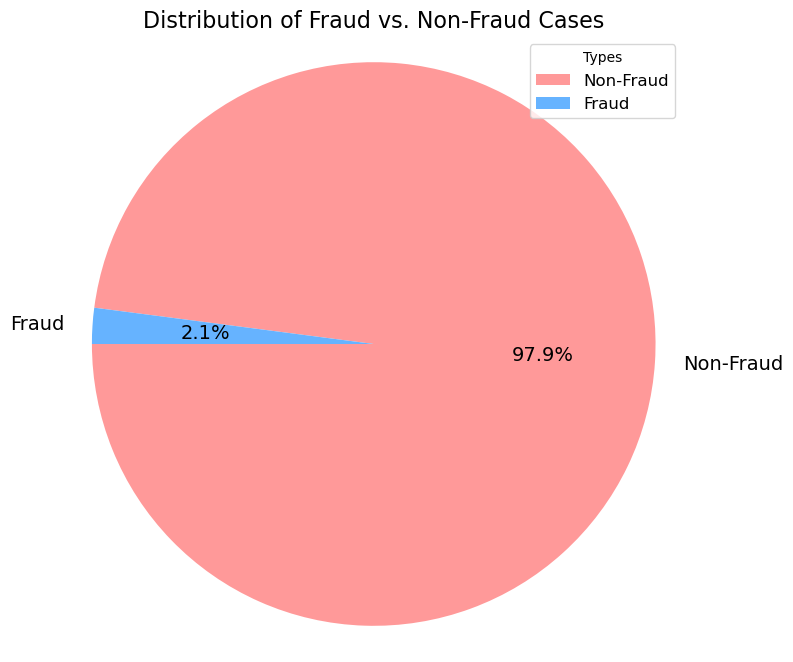

In [47]:
# Make a copy of the dataset
data_p = data2.copy()

# Create a new column with labels
data_p["Label_Type"] = np.where(data_p["Label"] == 1, "Fraud", "Non-Fraud")

# Define colors for the pie chart
colors = ['#ff9999', '#66b3ff']

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(data_p["Label_Type"].value_counts(), labels=data_p["Label_Type"].value_counts().index, autopct='%1.1f%%',
        startangle=180, colors=colors, textprops={'fontsize': 14})
plt.title('Distribution of Fraud vs. Non-Fraud Cases', fontsize=16)

# Add a legend
plt.legend(loc='upper right', labels=data_p["Label_Type"].value_counts().index, title='Types', fontsize=12)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Display the chart
plt.show()


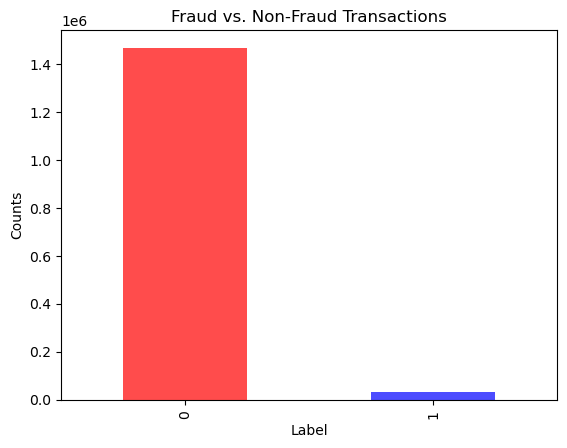

In [48]:
# Plot a bar chart of value counts for the 'Label' column
data2['Label'].value_counts().plot(kind='bar', color=['red', 'blue'], alpha=0.7)
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Fraud vs. Non-Fraud Transactions')
plt.show()

In [49]:
#Seperating the fraud and non fraud in order to describe them seperately
data2_non_fraud=data2[data2.Label == 0]
data2_fraud=data2[data2.Label == 1]
data2_fraud.head()

,Time_step,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,month,year,day,time,day_of_week,day_name,hour
11,2022-03-15 10:24:00,JPMC-CLIENT-8947,ACCOUNT-8957,UNITED STATES,23505.0,CLIENT-8965,ACCOUNT-8966,BENIN,857.13,1,QUICK-PAYMENT,3,2022,15,10:24:00,1,Tuesday,10
211,2022-03-15 22:54:00,Not Provided,Not Provided,Not Provided,Not Provided,JPMC-CLIENT-2492,ACCOUNT-2502,USA,684.52,1,DEPOSIT-CASH,3,2022,15,22:54:00,1,Tuesday,22
219,2022-03-15 23:04:00,JPMC-CLIENT-2492,ACCOUNT-2503,UNITED STATES,6909.0,JPMC-COMPANY-2495,ACCOUNT-2501,USA,787.80,1,MAKE-PAYMENT,3,2022,15,23:04:00,1,Tuesday,23
224,2022-03-15 23:14:00,JPMC-CLIENT-2492,ACCOUNT-2502,UNITED STATES,46666.0,Not Provided,Not Provided,Not Provided,194.67,1,WITHDRAWAL,3,2022,15,23:14:00,1,Tuesday,23
300,2022-03-16 11:14:00,JPMC-CLIENT-2492,ACCOUNT-2503,UNITED STATES,6337.0,JPMC-COMPANY-2494,ACCOUNT-2500,ALAND-ISLANDS,812.27,1,MOVE-FUNDS,3,2022,16,11:14:00,2,Wednesday,11


In [50]:
data2_non_fraud.shape
data2_non_fraud.describe()

,USD_amount,Label,month,year,day,day_of_week,hour
count,1.467358e+06,1467358.0,1.467358e+06,1.467358e+06,1.467358e+06,1.467358e+06,1.467358e+06
mean,5.064553e+02,0.0,6.503870e+00,2.037961e+03,1.575137e+01,3.005025e+00,1.147594e+01
std,4.591433e+02,0.0,3.428255e+00,9.407619e+00,8.799362e+00,1.999615e+00,6.909602e+00
min,0.000000e+00,0.0,1.000000e+00,2.022000e+03,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.355300e+02,0.0,4.000000e+00,2.030000e+03,8.000000e+00,1.000000e+00,5.000000e+00
50%,4.011900e+02,0.0,7.000000e+00,2.038000e+03,1.600000e+01,3.000000e+00,1.200000e+01
75%,7.330300e+02,0.0,9.000000e+00,2.046000e+03,2.300000e+01,5.000000e+00,1.700000e+01
max,1.985449e+04,0.0,1.200000e+01,2.054000e+03,3.100000e+01,6.000000e+00,2.300000e+01


In [51]:
data2_fraud.shape
data2_fraud.describe()

,USD_amount,Label,month,year,day,day_of_week,hour
count,30819.000000,30819.0,30819.000000,30819.000000,30819.000000,30819.000000,30819.000000
mean,847.442043,1.0,6.491645,2037.819430,16.060547,3.013660,11.504721
std,2003.566402,0.0,3.439937,9.322038,8.626739,2.016668,6.909650
min,100.000000,1.0,1.000000,2022.000000,1.000000,0.000000,0.000000
25%,254.115000,1.0,4.000000,2030.000000,9.000000,1.000000,6.000000
50%,512.230000,1.0,6.000000,2038.000000,16.000000,3.000000,11.000000
75%,773.975000,1.0,9.000000,2046.000000,23.000000,5.000000,18.000000
max,19998.940000,1.0,12.000000,2054.000000,31.000000,6.000000,23.000000


In [52]:
#Checking non-integer columns
data2_non_fraud.describe(include=object)

,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,Transaction_Type,time,day_name
count,1467358,1467358,1467358,1467358,1467358,1467358,1467358,1467358,1467358,1467358
unique,58193,74280,217,50001,278878,294549,253,8,29520,7
top,Not Provided,Not Provided,UNITED STATES,Not Provided,Not Provided,Not Provided,USA,MAKE-PAYMENT,06:06:29,Saturday
freq,214765,214765,979198,214765,210757,210757,742011,550192,184,210341


In [53]:
#Checking non-integer columns
data2_fraud.describe(include=object)

,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,Transaction_Type,time,day_name
count,30819,30819,30819,30819,30819,30819,30819,30819,30819,30819
unique,7981,11897,217,20759,14185,16517,253,8,18779,7
top,Not Provided,Not Provided,UNITED STATES,Not Provided,Not Provided,Not Provided,USA,QUICK-PAYMENT,09:46:12,Saturday
freq,4121,4121,21301,4121,5136,5136,15897,7935,10,4537


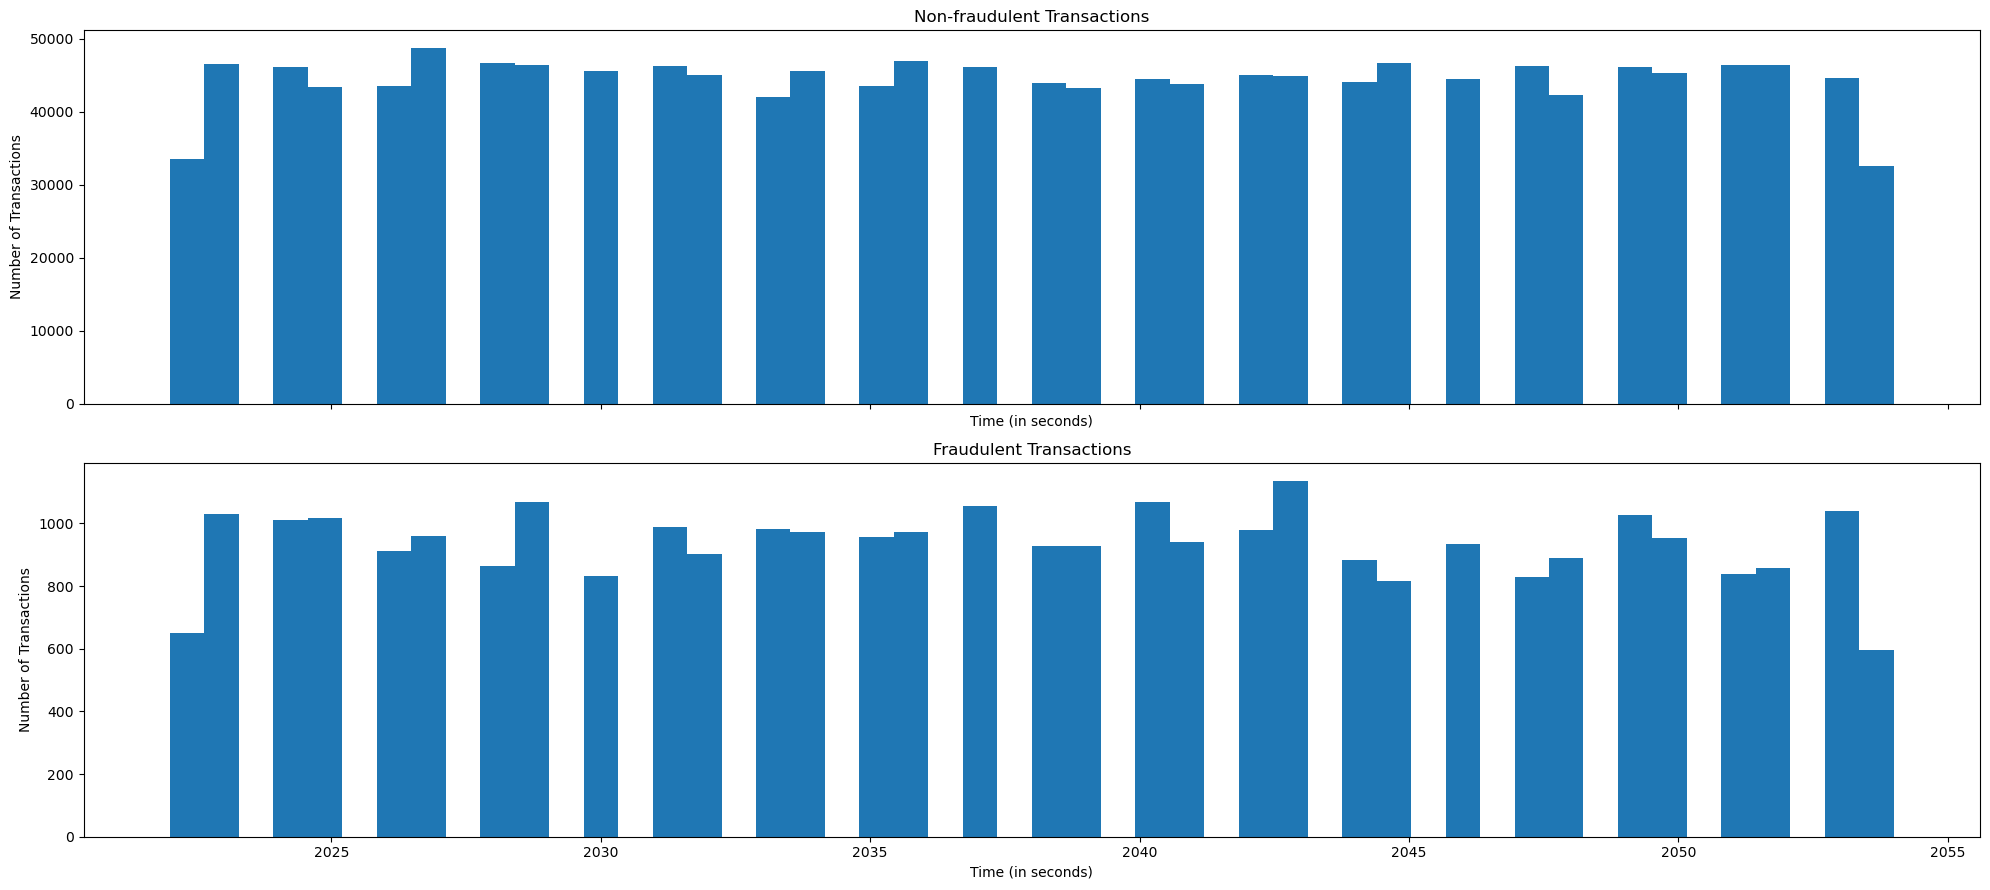

In [54]:
# Create two subplots sharing the same x-axis
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20, 9))
bins = 50

# Histogram for non-fraudulent transactions
ax1.hist(data2.year[data2.Label == 0], bins=bins)
ax1.set(xlabel='Time (in seconds)', ylabel='Number of Transactions', title='Non-fraudulent Transactions')

# Histogram for fraudulent transactions
ax2.hist(data2.year[data2.Label == 1], bins=bins)
ax2.set(xlabel='Time (in seconds)', ylabel='Number of Transactions', title='Fraudulent Transactions')

plt.tight_layout()
plt.show()


In [56]:
#data2.drop('is_weekend_normalized', axis=1, inplace=True)
data2.head()

,Time_step,Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Bene_Id,Bene_Account,Bene_Country,USD_amount,Label,Transaction_Type,month,year,day,time,day_of_week,day_name,hour
0,2022-03-15 10:24:00,JPMC-CLIENT-10098,ACCOUNT-10108,UNITED STATES,35537.0,Not Provided,Not Provided,Not Provided,558.43,0,WITHDRAWAL,3,2022,15,10:24:00,1,Tuesday,10
1,2022-03-15 10:24:00,JPMC-CLIENT-10098,ACCOUNT-10109,UNITED STATES,15287.0,CLIENT-10100,ACCOUNT-10106,CANADA,622.78,0,QUICK-PAYMENT,3,2022,15,10:24:00,1,Tuesday,10
2,2022-03-15 10:24:00,Not Provided,Not Provided,Not Provided,Not Provided,JPMC-CLIENT-9812,ACCOUNT-9826,USA,802.54,0,DEPOSIT-CASH,3,2022,15,10:24:00,1,Tuesday,10
3,2022-03-15 10:24:00,JPMC-CLIENT-9812,ACCOUNT-9825,UNITED STATES,38145.0,JPMC-CLIENT-9814,ACCOUNT-9824,USA,989.09,0,PAY-CHECK,3,2022,15,10:24:00,1,Tuesday,10
4,2022-03-15 10:24:00,Not Provided,Not Provided,Not Provided,Not Provided,JPMC-CLIENT-9789,ACCOUNT-9800,USA,786.78,0,DEPOSIT-CHECK,3,2022,15,10:24:00,1,Tuesday,10


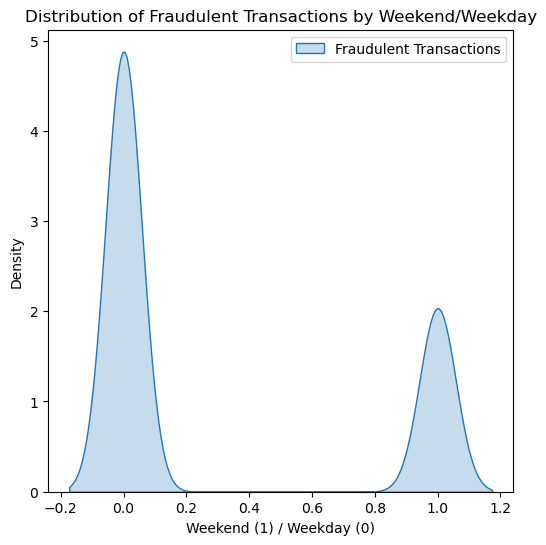

In [58]:
def categorize_day(day):
    if day in ['Saturday', 'Sunday']:
        return 1  # Weekend
    else:
        return 0  # Weekday

# Apply the categorization function to create a new 'is_weekend' column
data2['is_weekend'] = data2['day_name'].apply(categorize_day)

# Create a probability density plot (KDE) for fraudulent transactions by weekend/weekday
plt.figure(figsize=(6, 6))

# Plot KDE for fraudulent transactions and add a legend
sns.kdeplot(data2['is_weekend'][data2['Label'] == 1], label='Fraudulent Transactions', fill=True)

plt.xlabel('Weekend (1) / Weekday (0)')
plt.ylabel('Density')
plt.title('Distribution of Fraudulent Transactions by Weekend/Weekday')
plt.legend()
plt.show()


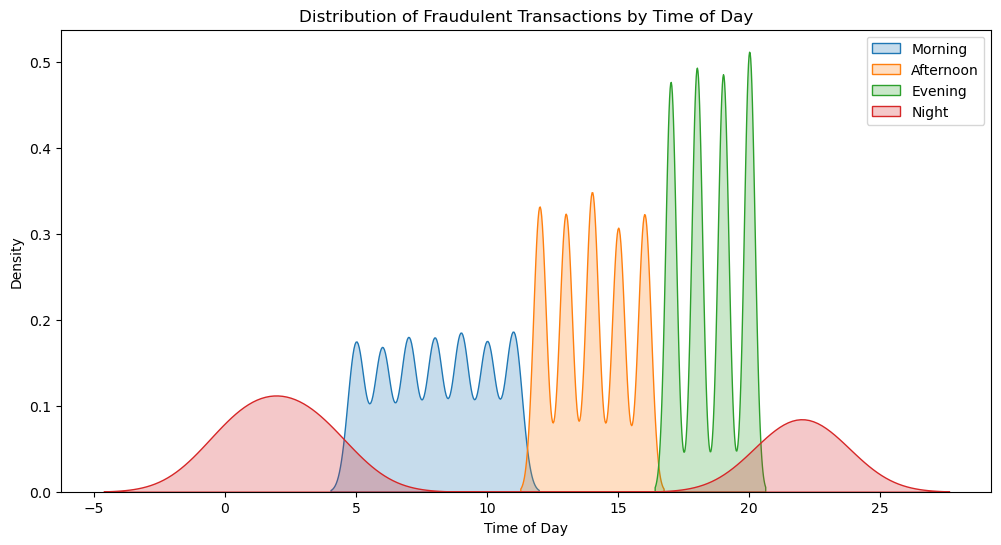

In [59]:
# Apply the categorization function to create a new 'time_of_day' column
data2['time_of_day'] = data2['hour'].apply(categorize_time)

# Create a probability density plot (KDE) for fraudulent transactions by time of day
plt.figure(figsize=(12, 6))

# Plot KDE for each time category and add a legend
for time_category in ['Morning', 'Afternoon', 'Evening', 'Night']:
    sns.kdeplot(data2['hour'][data2['time_of_day'] == time_category][data2['Label'] == 1], label=time_category, fill=True)

plt.xlabel('Time of Day')
plt.ylabel('Density')
plt.title('Distribution of Fraudulent Transactions by Time of Day')
plt.legend()
plt.show()


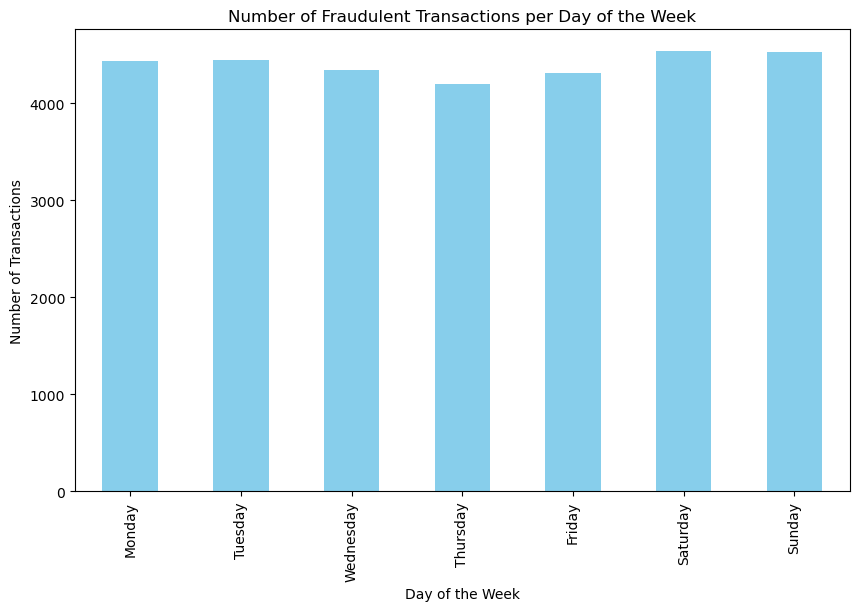

In [60]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame 'data2' with a 'day_of_week' column

# Count the number of transactions per day of the week
transactions_per_day = data2[data2['Label'] == 1]['day_of_week'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
transactions_per_day.plot(kind='bar', color='skyblue')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Transactions')
plt.title('Number of Fraudulent Transactions per Day of the Week')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()


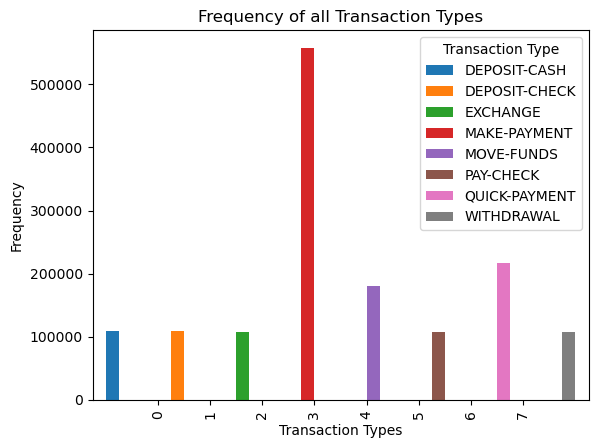

In [61]:
# Generate a frequency count of each category for each variable
counts = data2.groupby(['Transaction_Type']).size().reset_index(name='count')

# Create a grouped bar plot with thicker bars
fig, ax = plt.subplots()
ax = counts.pivot(columns='Transaction_Type', values='count').plot(kind='bar', ax=ax, width=2)  # Adjust the width here

ax.set_title('Frequency of all Transaction Types')
ax.set_xlabel('Transaction Types')
ax.set_ylabel('Frequency')
ax.legend(title='Transaction Type')

plt.show()

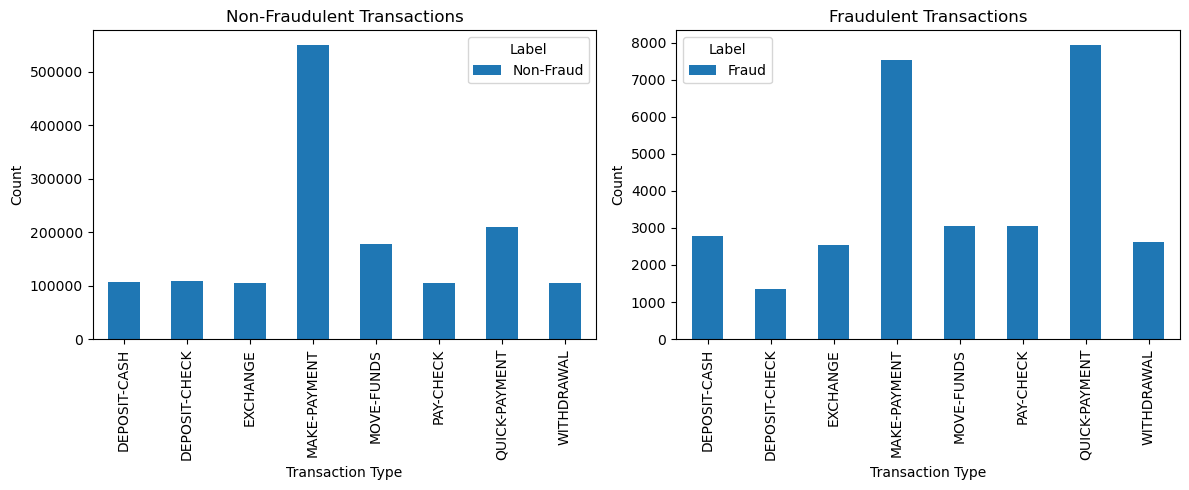

In [62]:
# Group and count non-fraudulent transactions by Transaction_Type and Label
counts_nf = data2_non_fraud.groupby(['Transaction_Type', 'Label']).size().reset_index(name='count')

# Group and count fraudulent transactions by Transaction_Type and Label
counts_f = data2_fraud.groupby(['Transaction_Type', 'Label']).size().reset_index(name='count')

# Create grouped bar plots for non-fraudulent and fraudulent transactions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Create a 1x2 subplot

# Non-fraudulent transactions
counts_nf.pivot(index='Transaction_Type', columns='Label', values='count').plot(kind='bar', ax=ax1)
ax1.set_title('Non-Fraudulent Transactions')
ax1.set_xlabel('Transaction Type')
ax1.set_ylabel('Count')
ax1.legend(title='Label', labels=['Non-Fraud', 'Fraud'])

# Fraudulent transactions
counts_f.pivot(index='Transaction_Type', columns='Label', values='count').plot(kind='bar', ax=ax2)
ax2.set_title('Fraudulent Transactions')
ax2.set_xlabel('Transaction Type')
ax2.set_ylabel('Count')
ax2.legend(title='Label', labels=['Fraud', 'Fraud'])

plt.tight_layout()  # Ensure proper spacing of subplots
plt.show()


In [66]:
# Scale numerical features, e.g., using StandardScaler
scaler = StandardScaler()
data2[['USD_amount']] = scaler.fit_transform(data2[['USD_amount']])

In [67]:
# Group the data by 'month' and 'transaction_type' and count the occurrences
grouped_by_month = data2.groupby(['month', 'Transaction_Type']).size().unstack(fill_value=0)

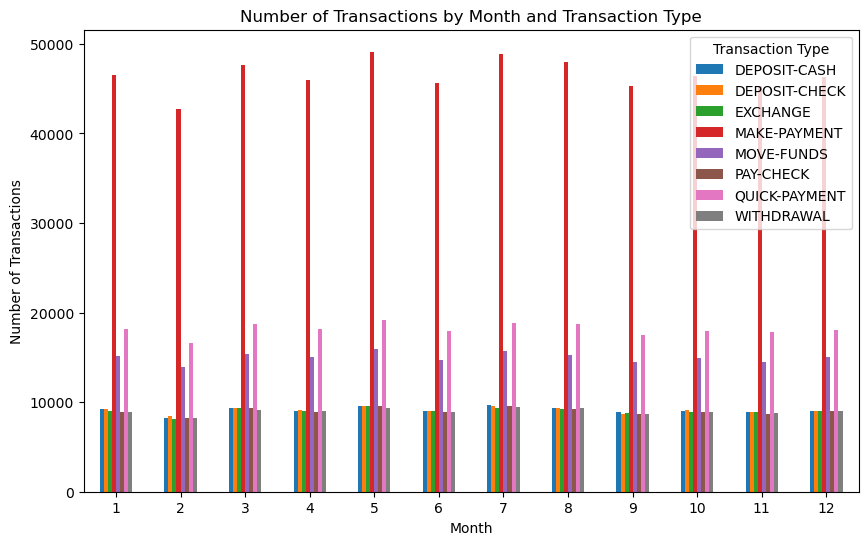

In [68]:
ax = grouped_by_month.plot(kind='bar', figsize=(10, 6))
ax.set_xlabel('Month')
ax.set_ylabel('Number of Transactions')
ax.set_title('Number of Transactions by Month and Transaction Type')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.legend(title='Transaction Type', loc='upper right')
plt.show()

USD_amount               0.089663
Label                    1.000000
month                   -0.000506
year                    -0.002139
day                      0.004989
day_of_week              0.000613
hour                     0.000591
is_weekend               0.002411
trans_type_mean_fraud    0.058609
Sender_CountryLabels     0.007651
Bene_CountryLabels       0.011141
Name: Label, dtype: float64


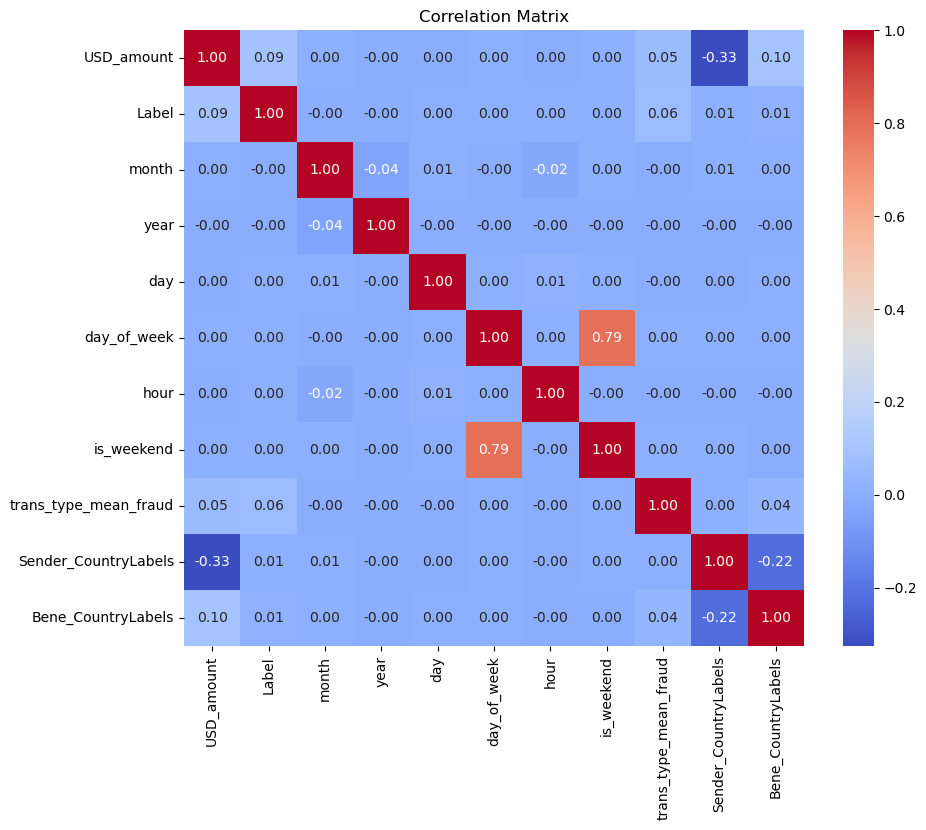

In [69]:
#Used Target encoding for transaction types as QUICK-PAYMENT and MAKE-PAYMENT are most likely fraud
# Calculate the average fraud rate for each transaction type
trans_type_means = data2.groupby('Transaction_Type')['Label'].mean().to_dict()

# Create a new feature using the target encoding
data2['trans_type_mean_fraud'] = data2['Transaction_Type'].map(trans_type_means)

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the "Countries" column
data2["Sender_CountryLabels"] = label_encoder.fit_transform(data2["Sender_Country"])
data2["Bene_CountryLabels"] = label_encoder.fit_transform(data2["Bene_Country"])
#data2["Transaction_Type"] = label_encoder.fit_transform(data2["Transaction_Type"]) try to label encode instead
# Select only the numeric columns and 'Label' for correlation analysis
numeric_columns = data2.select_dtypes(include=['int64', 'float64'])
numeric_columns['Label'] = data2['Label']


# Calculate the Pearson correlation coefficients
correlation_matrix = numeric_columns.corr()

# Print the correlation matrix
print(correlation_matrix['Label'])

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()
#data2.head()

#negative correlation between the label and the month and year. so these colums will be dropped.

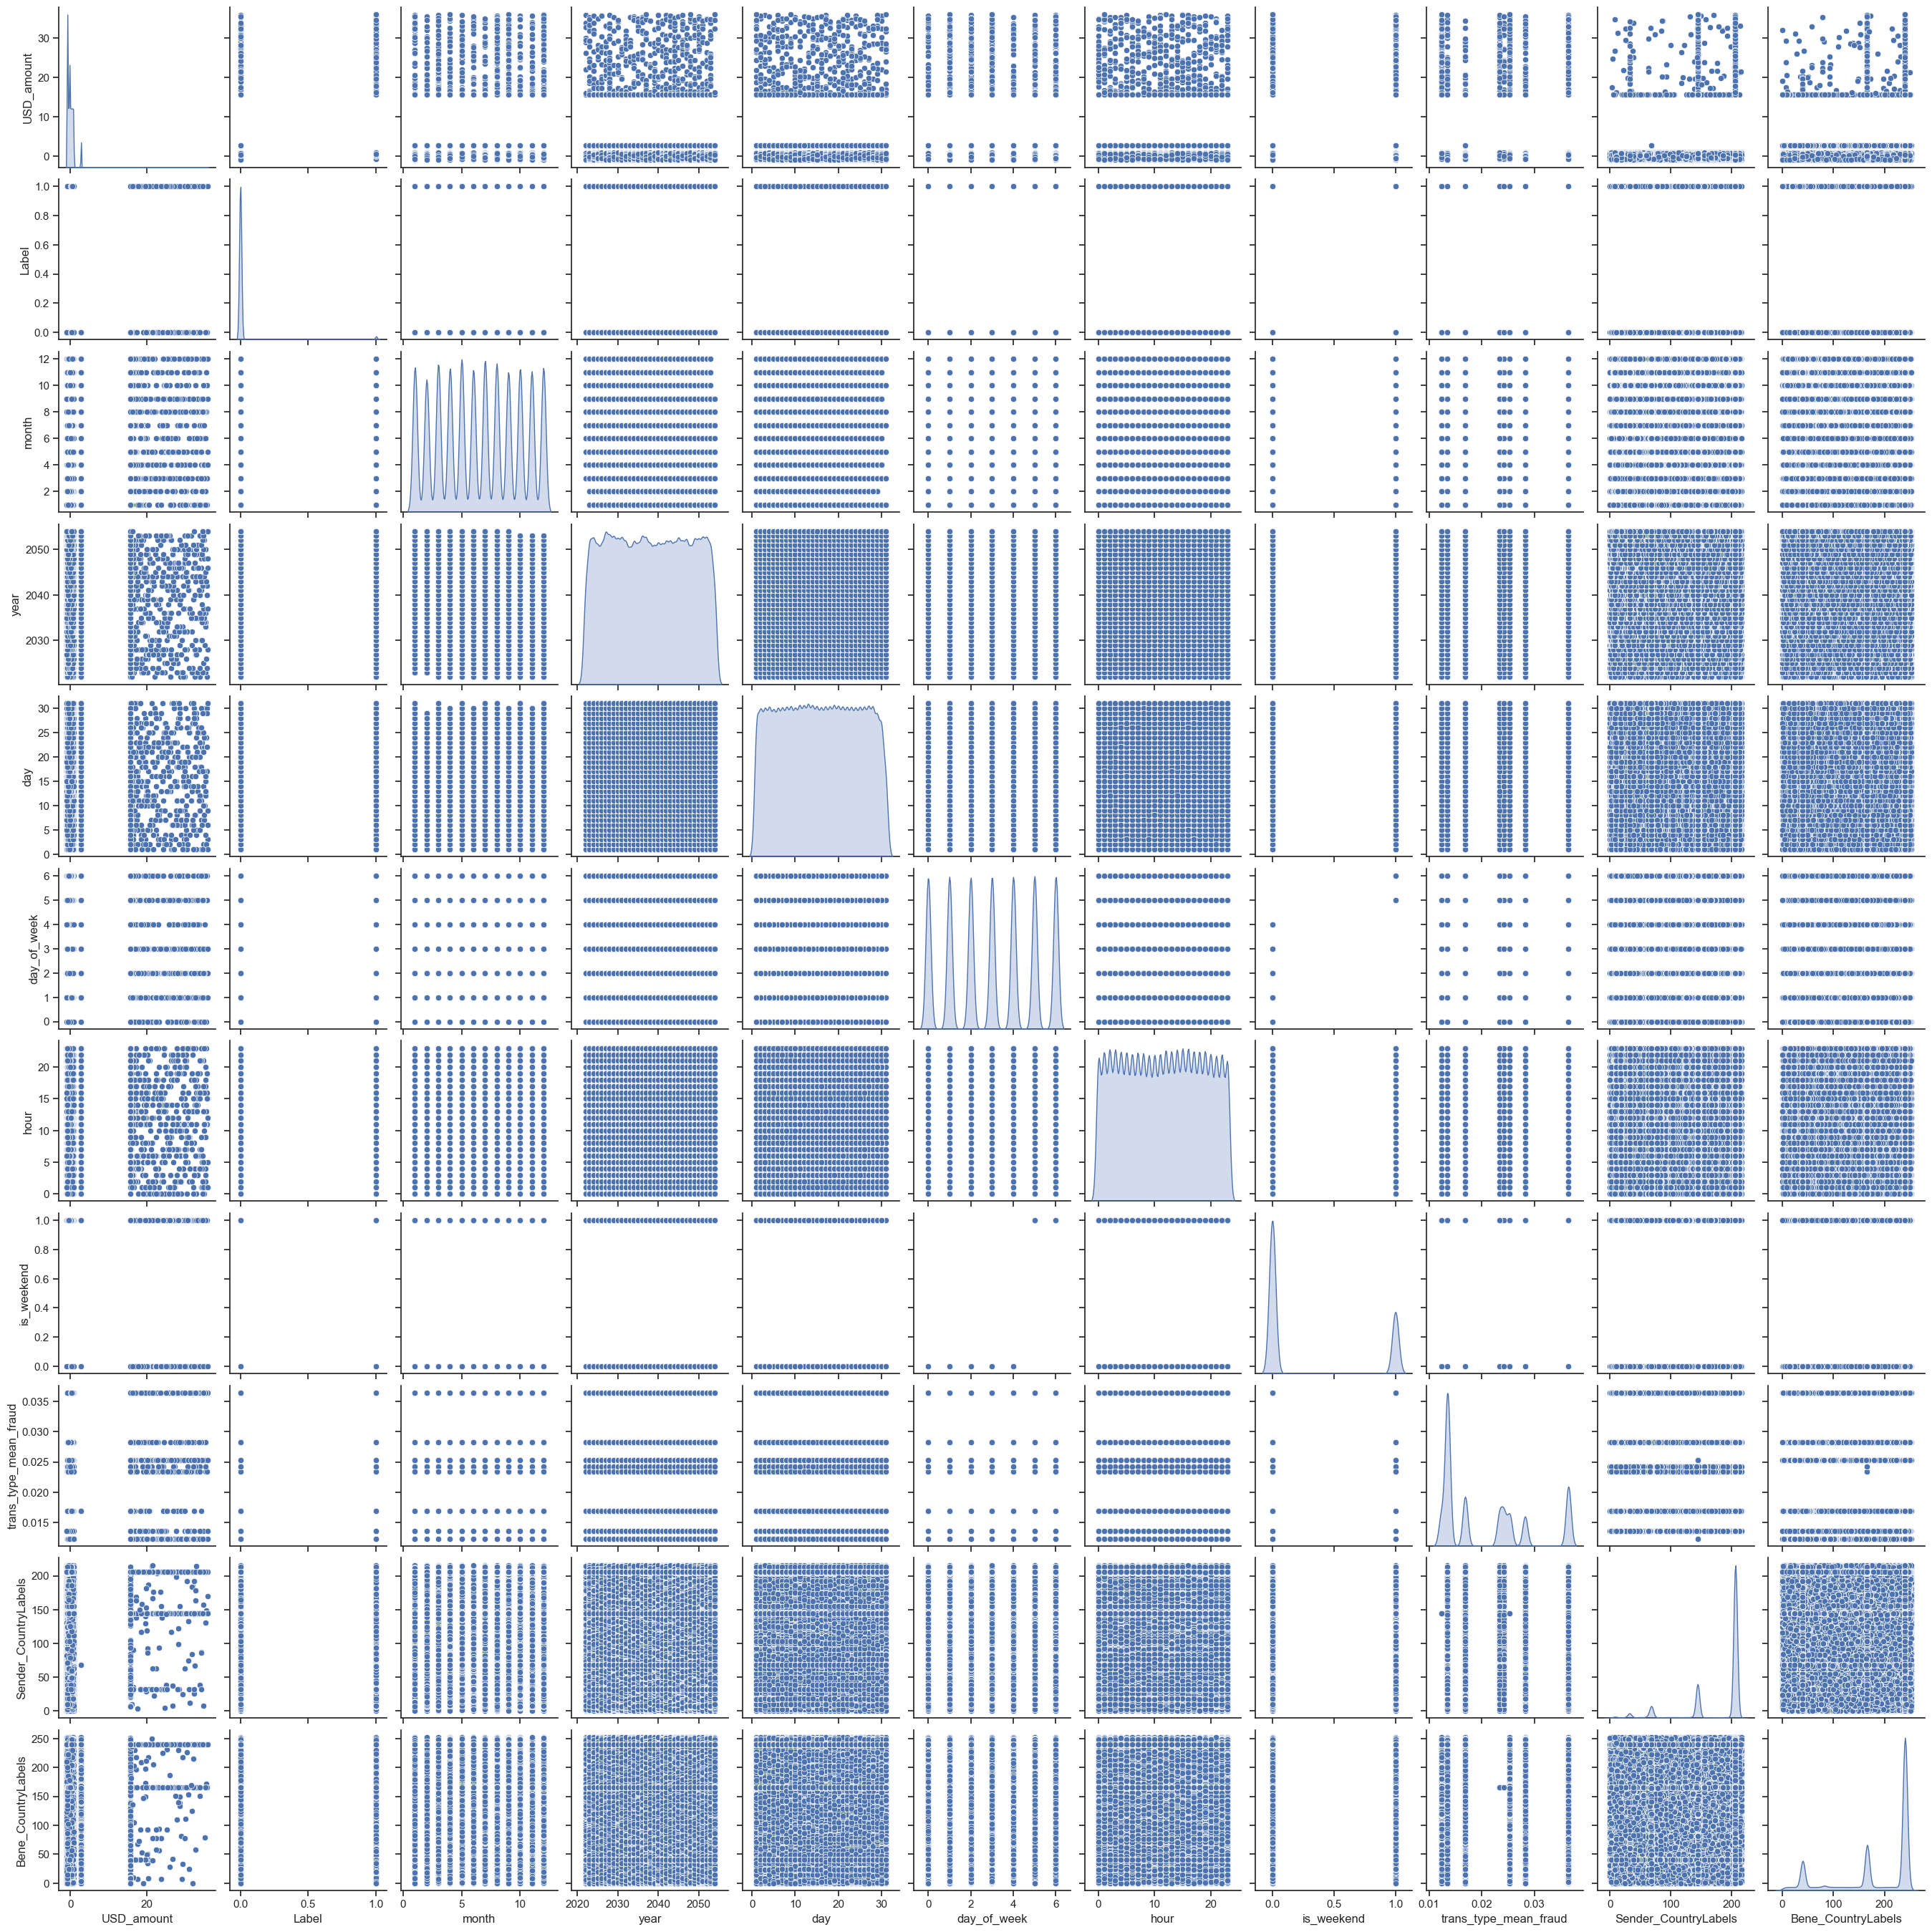

In [70]:
sns.set(style="ticks")
sns.pairplot(data2, kind="scatter", diag_kind="kde")
plt.show()

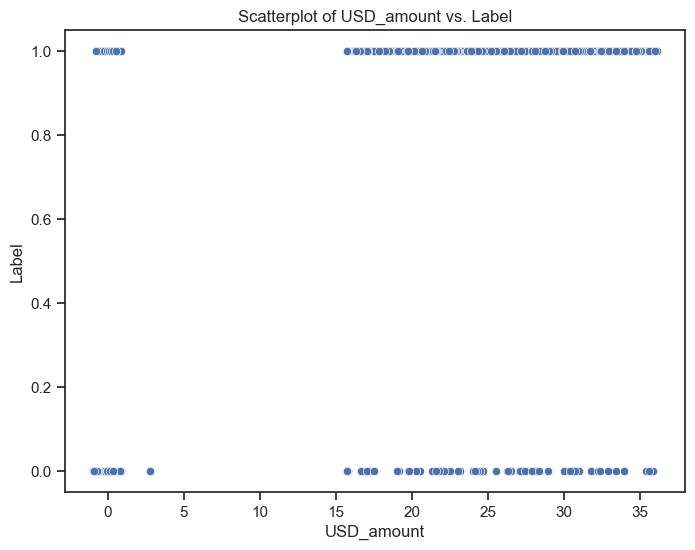

In [71]:
# Assuming you have a DataFrame df with numerical columns

# Create a list of numerical column names
numerical_columns = data2[['USD_amount','Label']] # Adjust this as needed

# Create separate scatterplots for each pair of numerical variables
for (x, y) in itertools.combinations(numerical_columns, 2):
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    sns.scatterplot(data=data2, x=x, y=y)
    plt.title(f'Scatterplot of {x} vs. {y}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

In [72]:
#Make features independent
x = data2[['USD_amount', 'trans_type_mean_fraud', 'day', 'day_of_week', 'hour', 'is_weekend','Sender_CountryLabels','Bene_CountryLabels']]
y = data2['Label']

In [73]:
x.head()
#y.head()

,USD_amount,trans_type_mean_fraud,day,day_of_week,hour,is_weekend,Sender_CountryLabels,Bene_CountryLabels
0,0.083289,0.024228,15,1,10,0,206,166
1,0.202498,0.036465,15,1,10,0,206,40
2,0.535505,0.025336,15,1,10,0,144,240
3,0.881090,0.028233,15,1,10,0,206,240
4,0.506309,0.012322,15,1,10,0,144,240


In [74]:
# Separate features (X) and the target variable (y)
# X = data.drop(columns=['Label'])  # Features
# y = data['Label']  # Target variable

# Display the class distribution before SMOTE
class_distribution_before = Counter(y)
print(f'Class distribution before SMOTE: {class_distribution_before}')

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

# Display the class distribution after SMOTE
class_distribution_after = Counter(y_resampled)
print(f'Class distribution after SMOTE: {class_distribution_after}')

# Now you can use X_resampled and y_resampled for training your model



Class distribution before SMOTE: Counter({0: 1467358, 1: 30819})
Class distribution after SMOTE: Counter({0: 1467358, 1: 1467358})


In [75]:
#Balanced the data before I splitted it 
#x_train,x_test,y_train,y_test=train_test_split(x_resampled, y_resampled,test_size=0.30,random_state=42)

### Trying undersampling to check the difference in the modela perfomance

In [86]:
# Assuming df is your DataFrame with the data
desired_ratio = 1  # Change this to your desired ratio
majority_class = data2[data2['Label'] == 'majority_class']
minority_class = data2[data2['Label'] == 'minority_class']

# Randomly sample majority class to match the desired ratio
majority_class_undersampled = majority_class.sample(n=len(minority_class) * desired_ratio, random_state=42)

# Combine the minority and undersampled majority class
undersampled_data = pd.concat([majority_class_undersampled, minority_class])

# Now, you have a balanced dataset in "undersampled_data"
# To get the dimensions of the DataFrame, use the 'shape' attribute without parentheses
df = pd.DataFrame(undersampled_data)
dimensions = df.shape  # Correct usage to get the dimensions

# Print the dimensions
print(dimensions)

####Does'nt work for now


(0, 23)


In [87]:
#making batches since I hace a large data set
# Define the mini-batch size
#mini_batch_size = 10

# Create mini-batches
#mini_batches_x = [x_train[i:i + mini_batch_size] for i in range(0, len(x_train), mini_batch_size)]
#mini_batches_y = [y_train[i:i + mini_batch_size] for i in range(0, len(y_train), mini_batch_size)]

In [88]:
#for RFC
X_train, X_temp, y_train, y_temp = train_test_split(x_resampled, y_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)

#for XGBOOST
X_train2, X_temp2, y_train2, y_temp2 = train_test_split(x_resampled, y_resampled, test_size=0.3, random_state=42)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_temp2, y_temp2, test_size=0.3, random_state=42)

# Random forest classification model

In [89]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)

# Use GridSearchCV to find the best combination of hyperparameters
best_accuracy = 0.0
best_params = None

In [90]:
for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                # Create a Random Forest Classifier with the current hyperparameters
                clf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42
                )

In [91]:
# Train the model on the training set
clf.fit(X_train, y_train)
                
# Evaluate the model on the validation set
val_accuracy = clf.score(X_val, y_val)
                
if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    best_params = {'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf
                    }

In [141]:
# Train a model with the best hyperparameters on the full training set
best_clf = RandomForestClassifier(random_state=42, **best_params)
#best_clf.fit(X_train, y_train)

#with open('best_clf.pkl', 'wb') as file:
    #pickle.dump(best_clf, file)

 #Load the model
with open('best_clf.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [142]:
# Evaluate the model on the test set
test_accuracy = loaded_model.score(X_test, y_test)
print("Best Hyperparameters:", best_params)
print("Test Set Accuracy:", test_accuracy)

Best Hyperparameters: {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4}
Test Set Accuracy: 0.8632920018930431


In [131]:
feature_importance=loaded_model.feature_importances_
print(feature_importance)

#x = data2[['USD_amount', 'trans_type_mean_fraud', 'day', 'day_of_week', 'hour', 'is_weekend','Sender_CountryLabels','Bene_CountryLabels']]


[0.22034064 0.57474399 0.03885484 0.02264477 0.0343603  0.00466995
 0.05197569 0.05240983]


In [135]:
# Make predictions on the test data
y_pred = loaded_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)

Accuracy: 0.86
Confusion Matrix:
[[118883  12743]
 [ 23365 109134]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87    131626
           1       0.90      0.82      0.86    132499

    accuracy                           0.86    264125
   macro avg       0.87      0.86      0.86    264125
weighted avg       0.87      0.86      0.86    264125



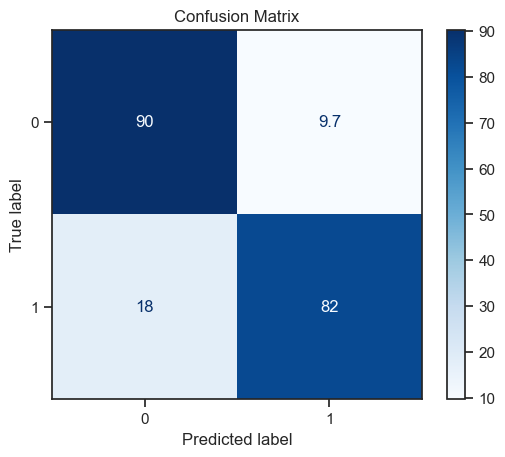

Confusion Matrix Percentages:
[[90.318782    9.681218  ]
 [17.63409535 82.36590465]]


In [140]:
ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1]).plot(cmap='Blues')
# Calculate percentages
conf_matrix = 100 * conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.title('Confusion Matrix')
plt.show()
print('Confusion Matrix Percentages:')
print(conf_matrix)


In [117]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

Precision: 0.90
Recall: 0.82
F1-Score: 0.86


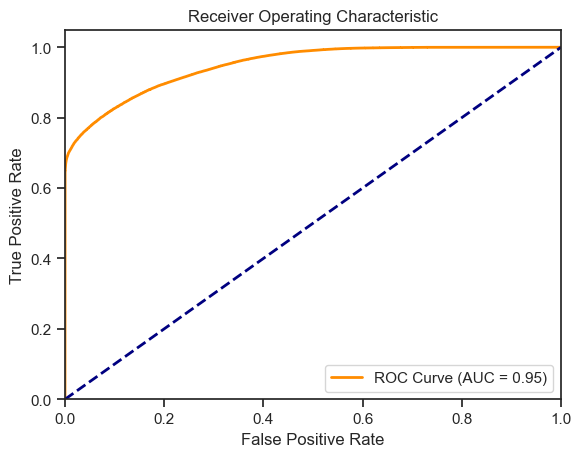

In [137]:
y_scores = loaded_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
auc = roc_auc_score(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


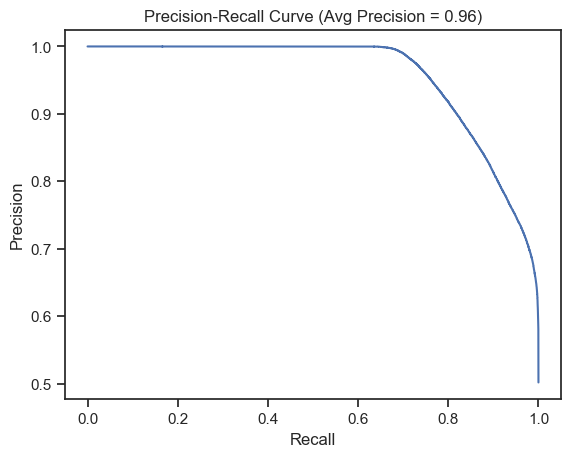

In [119]:
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (Avg Precision = {avg_precision:.2f})')
plt.show()

In [120]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87    131626
           1       0.90      0.82      0.86    132499

    accuracy                           0.86    264125
   macro avg       0.87      0.86      0.86    264125
weighted avg       0.87      0.86      0.86    264125



# XGBoost to compare with the random forest classifier

In [121]:
XGBCmodel = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    objective='binary:logistic'  # For binary classification
)

In [122]:
XGBCmodel.fit(X_train2, y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [123]:
y_pred2 = XGBCmodel.predict(X_test2)

# Evaluate the model
accuracy = accuracy_score(y_test2, y_pred2)
conf_matrix = confusion_matrix(y_test2, y_pred2)
classification_rep = classification_report(y_test2, y_pred2)

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_rep)


Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.91      0.82    131626
           1       0.88      0.70      0.78    132499

    accuracy                           0.80    264125
   macro avg       0.82      0.80      0.80    264125
weighted avg       0.82      0.80      0.80    264125



In [124]:
feature_importance2=XGBCmodel.feature_importances_
print(feature_importance)

#x = data2[['USD_amount', 'trans_type_mean_fraud', 'day', 'day_of_week', 'hour', 'is_weekend','Sender_CountryLabels','Bene_CountryLabels']]


[0.22034064 0.57474399 0.03885484 0.02264477 0.0343603  0.00466995
 0.05197569 0.05240983]


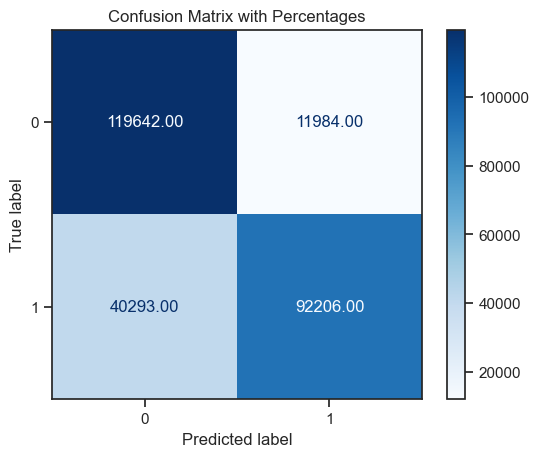

Confusion Matrix:
[[119642  11984]
 [ 40293  92206]]
Confusion Matrix Percentages:
[[90.8954158   9.1045842 ]
 [30.41004083 69.58995917]]


In [125]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test2, y_pred2)

# Calculate percentages
conf_matrix_percentages = 100 * conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix with percentages
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap='Blues', values_format='.2f')  # '.2f' for two decimal places
plt.title('Confusion Matrix with Percentages')
plt.show()

# Print the confusion matrix and percentages
print('Confusion Matrix:')
print(conf_matrix)

print('Confusion Matrix Percentages:')
print(conf_matrix_percentages)

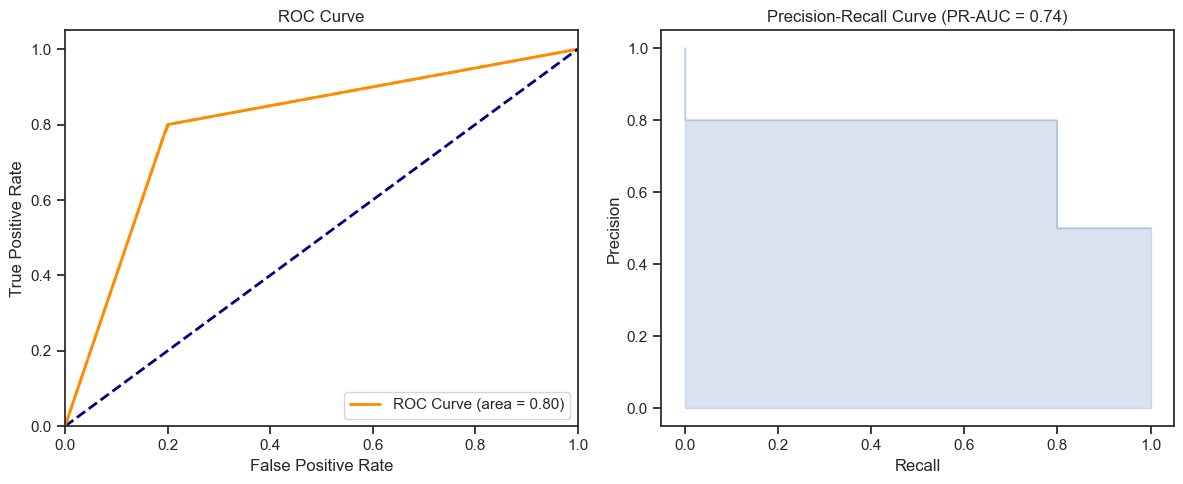

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# Assuming you have y_test2 and y_pred2
y_test2 = [1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
y_pred2 = [1, 0, 1, 1, 0, 0, 0, 1, 1, 0]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test2, y_pred2)
roc_auc = roc_auc_score(y_test2, y_pred2)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test2, y_pred2)
pr_auc = average_precision_score(y_test2, y_pred2)

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Plot ROC Curve
plt.subplot(1, 2, 1)  # Subplot 1
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Interpolate the ROC curve for a smoother plot
tpr_interp = np.interp(np.linspace(0, 1, 100), fpr, tpr)
plt.plot(np.linspace(0, 1, 100), tpr_interp, lw=2, linestyle='--', color='darkorange')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Plot Precision-Recall Curve
plt.subplot(1, 2, 2)  # Subplot 2
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (PR-AUC = {pr_auc:.2f})')

plt.tight_layout()  # Ensures the subplots don't overlap

plt.show()
